# Auto Insurance bodywork claim prediction

## Data preprocessing

The large size of the original datasets will fail to upload to GitHub later.  Therefore, data preprocessing has been performed in a separated notebook, and the cleaned DataFrame is saved as 'df.csv' ready for use.

### 3 original datasets:
- Traffic Crashes - Crashes
- Traffic Crashes - Vehicles
- Traffic Crashes - People

### Preview and inspect all 3 datasets:
- Inspecting the datasets.
- Based on project assumptions, adjust the DataFrames:
    - From df_crash, select ‘INJURIES_TOTAL’ = ‘0’
    - From df_people, select ‘PERSON_TYPE’ = ‘DRIVER’
    - From df_vehicle, select ‘UNIT_TYPE’ = ‘DRIVER’
    - From df_vehicle, select ‘VEHICLE_USE’ = ‘PERSONAL’

- Explore each column and decide what to keep.
- Merge all 3 DataFrames on column 'CRASH_RECORD_ID' and drop all null.
- Convert column 'AGE' and 'VEHICLE_YEAR' Dtype from float64 to int for for smaller data size.
- Save the cleaned DataFrame as 'df.csv'>


## Import libraries and load the cleaned DataFarame

In [1]:
# import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

## Inspect and adjust DataFrame

In [2]:
df = pd.read_csv('df_clean.csv')
df.head()

,Unnamed: 0,CRASH_DATE,DEVICE_CONDITION,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT,DAMAGE,ZIPCODE,SEX,AGE,MAKE,MODEL,VEHICLE_YEAR
0,0,12/31/2021 12:45:00 PM,NO CONTROLS,10,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"$501 - $1,500",60619,M,44,CHEVROLET,MALIBU,2016
1,1,12/31/2021 12:45:00 PM,NO CONTROLS,10,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"$501 - $1,500",60619,M,44,JEEP,PATRIOT,2017
2,2,12/31/2021 12:45:00 PM,NO CONTROLS,10,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"$501 - $1,500",60620,F,57,CHEVROLET,MALIBU,2016
3,3,12/31/2021 12:45:00 PM,NO CONTROLS,10,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"$501 - $1,500",60620,F,57,JEEP,PATRIOT,2017
4,4,12/31/2021 12:40:00 PM,FUNCTIONING PROPERLY,30,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"OVER $1,500",60641,M,47,HONDA,FIT,2009


In [3]:
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227016 entries, 0 to 227015
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CRASH_DATE            227016 non-null  object
 1   DEVICE_CONDITION      227016 non-null  object
 2   POSTED_SPEED_LIMIT    227016 non-null  int64 
 3   WEATHER_CONDITION     227016 non-null  object
 4   LIGHTING_CONDITION    227016 non-null  object
 5   ROADWAY_SURFACE_COND  227016 non-null  object
 6   ROAD_DEFECT           227016 non-null  object
 7   DAMAGE                227016 non-null  object
 8   ZIPCODE               227016 non-null  int64 
 9   SEX                   227016 non-null  object
 10  AGE                   227016 non-null  int64 
 11  MAKE                  227016 non-null  object
 12  MODEL                 227016 non-null  object
 13  VEHICLE_YEAR          227016 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 24.2+ MB


In [4]:
df['DAMAGE'].value_counts(normalize=True)

OVER $1,500      0.640920
$501 - $1,500    0.277558
$500 OR LESS     0.081523
Name: DAMAGE, dtype: float64

### Reset target df['DAMAGE'] from 3 outcomes to 2 outcomes

- OVER 1,500 = 1
- 501 - 1,500 = 1
- 500 OR LESS = 0

In [5]:
# In df['DAMAGE'], replace '$501 - $1,500' and 'OVER $1,500' with 'Over $500':
df_main = df.copy()
df_main['DAMAGE'] = df_main['DAMAGE'].replace(['$501 - $1,500', 'OVER $1,500'], '$501 AND OVER')

In [6]:
df_main['DAMAGE'].value_counts(normalize=True)

$501 AND OVER    0.918477
$500 OR LESS     0.081523
Name: DAMAGE, dtype: float64

### Reset date range for smaller size and drop 'CRASH_DATE'

In [7]:
df_main = df_main.sort_values(by='CRASH_DATE', ascending=False)[:80000]
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 79999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CRASH_DATE            80000 non-null  object
 1   DEVICE_CONDITION      80000 non-null  object
 2   POSTED_SPEED_LIMIT    80000 non-null  int64 
 3   WEATHER_CONDITION     80000 non-null  object
 4   LIGHTING_CONDITION    80000 non-null  object
 5   ROADWAY_SURFACE_COND  80000 non-null  object
 6   ROAD_DEFECT           80000 non-null  object
 7   DAMAGE                80000 non-null  object
 8   ZIPCODE               80000 non-null  int64 
 9   SEX                   80000 non-null  object
 10  AGE                   80000 non-null  int64 
 11  MAKE                  80000 non-null  object
 12  MODEL                 80000 non-null  object
 13  VEHICLE_YEAR          80000 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 9.2+ MB


In [8]:
# Take out 'ZIPCODE' and re-run the models

df_main = df_main.drop(['CRASH_DATE'], axis=1)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 79999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   DEVICE_CONDITION      80000 non-null  object
 1   POSTED_SPEED_LIMIT    80000 non-null  int64 
 2   WEATHER_CONDITION     80000 non-null  object
 3   LIGHTING_CONDITION    80000 non-null  object
 4   ROADWAY_SURFACE_COND  80000 non-null  object
 5   ROAD_DEFECT           80000 non-null  object
 6   DAMAGE                80000 non-null  object
 7   ZIPCODE               80000 non-null  int64 
 8   SEX                   80000 non-null  object
 9   AGE                   80000 non-null  int64 
 10  MAKE                  80000 non-null  object
 11  MODEL                 80000 non-null  object
 12  VEHICLE_YEAR          80000 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 8.5+ MB


In [9]:
# Checking Null:

df_main.isna().sum()

DEVICE_CONDITION        0
POSTED_SPEED_LIMIT      0
WEATHER_CONDITION       0
LIGHTING_CONDITION      0
ROADWAY_SURFACE_COND    0
ROAD_DEFECT             0
DAMAGE                  0
ZIPCODE                 0
SEX                     0
AGE                     0
MAKE                    0
MODEL                   0
VEHICLE_YEAR            0
dtype: int64

In [10]:
# Checking memory usage:

df_main.memory_usage(deep=True)

Index                    640000
DEVICE_CONDITION        5780744
POSTED_SPEED_LIMIT       640000
WEATHER_CONDITION       4984405
LIGHTING_CONDITION      5522834
ROADWAY_SURFACE_COND    4845084
ROAD_DEFECT             5362084
DAMAGE                  7649093
ZIPCODE                  640000
SEX                     4960000
AGE                      640000
MAKE                    5250347
MODEL                   5210664
VEHICLE_YEAR             640000
dtype: int64

## Prepare for modeling

### Define X and y, perform train_test_split

In [11]:
# define X and y:

X = df_main.drop('DAMAGE', axis=1)
y = df_main['DAMAGE']

# train_test_split:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

### Using Pipeline and FunctionTransformer

In [12]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int64'])

In [13]:
# The FunctionTransformer will turn my function into a transformer:

GrabNumeric = FunctionTransformer(grab_numeric)

In [14]:
# Pipe:

pipe = Pipeline([
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])

In [15]:
# checking the resualt:

pipe.fit_transform(X_train)

array([[ 0.15215557,  0.28210137, -0.66542321, -0.84450629],
       [ 0.15215557,  0.24063767, -1.13243316,  0.70247517],
       [-1.72916821,  0.32356507,  1.00246947, -0.67261946],
       ...,
       [ 0.15215557,  0.10795384, -0.46527609, -0.15695897],
       [-5.49181578,  0.32356507,  1.60291083,  0.53058834],
       [-1.72916821,  0.28210137,  0.66889093, -0.50073263]])

### Using Pipeline and ColumnTransformer


#### We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical

- numbers (AGE, VEHICLE_YEAR)
 - scale, impute

- categorical (all other columuns)
 - OHE, impute

In [16]:
# Numeric pipeline:

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

In [17]:
# Categorical pipeline:

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

### Selector and ColumnTransformer
This will return a callable list of columns

In [18]:
# The "remainder='passthrough" tells the compiler to leave the other df columns unchanged.
# The `ColumnTransformer` will take care of our preprocessing, so now we can add our model at the end of the pipeline:

CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include='int64')),
    ('cat_trans', cat_pipe, selector(dtype_include=object))
], remainder='passthrough')

In [19]:
# testing Selector:

test = selector(dtype_include='int64')
test(X_train)

['POSTED_SPEED_LIMIT', 'ZIPCODE', 'AGE', 'VEHICLE_YEAR']

## Bringing in Our Modeling Class from before

In [20]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        
        # Validate score on test data
        self.cv_results_test = cross_val_score(self.model, X_test, y_test, cv=kfolds)
        self.cv_test_mean = np.mean(self.cv_results_test)
        
    def print_cv_summary(self):
        cv_summary = self.cv_mean
        return cv_summary
        
#         cv_summary = (
#         f'''CV Results for `{self.name}` model:
#             {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
#         ''')
#         print(cv_summary)


    def print_cv_test_summary(self):
        cv_test_summary = self.cv_test_mean
        return cv_test_summary


    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

### Create containers to store confusion_matrix and the 4 scores

In [21]:
cf_matrix_train_list = []
cf_matrix_test_list = []

accuracy_train_dict = {}
recall_train_dict = {}
precision_train_dict = {}
f1_train_dict = {}

accuracy_test_dict = {}
recall_test_dict = {}
precision_test_dict = {}
f1_test_dict = {}

In [22]:
def add_4scores_train(model_name):
    accuracy_train_dict[model_name] = accuracy_score(y_train, y_hat_train)
    recall_train_dict[model_name] = recall_score(y_train, y_hat_train, pos_label='$501 AND OVER')
    precision_train_dict[model_name] = precision_score(y_train, y_hat_train, pos_label='$501 AND OVER')
    f1_train_dict[model_name] = f1_score(y_train, y_hat_train, pos_label='$501 AND OVER')

In [23]:
def add_4scores_test(model_name):
    accuracy_test_dict[model_name] = accuracy_score(y_test, y_hat_test)
    recall_test_dict[model_name] = recall_score(y_test, y_hat_test, pos_label='$501 AND OVER')
    precision_test_dict[model_name] = precision_score(y_test, y_hat_test, pos_label='$501 AND OVER')
    f1_test_dict[model_name] = f1_score(y_test, y_hat_test, pos_label='$501 AND OVER')

In [24]:
def print_4scores_train(model_name):
    return print(f"""
The model's accuracy on the train set is {round(accuracy_train_dict[model_name], 4)} \n
The model's recall on the train set is {round(recall_train_dict[model_name], 4)} \n
The model's precision on the train set is {round(precision_train_dict[model_name], 4)} \n
The model's f1-score on the train is {round(f1_train_dict[model_name], 4)}
""")

In [25]:
def print_4scores_test(model_name):
    return print(f"""
The model's accuracy on the test set is {round(accuracy_test_dict[model_name], 4)} \n
The model's recall on the test set is {round(recall_test_dict[model_name], 4)} \n
The model's precision on the test set is {round(precision_test_dict[model_name], 4)} \n
The model's f1-score on the test is {round(f1_test_dict[model_name], 4)}
""")

## Models

### Model 1: Create Baseline Model - Dummy Classifier Model

In [26]:
dummy_model = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [27]:
# Use the class without dummy pipe:

dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy', X = X_train, y = y_train)

In [28]:
# Score on training data:

dummy_score_train = dummy_model_pipe.print_cv_summary()
dummy_score_train

0.9178171641791044

In [29]:
# Validate with testing data:

dummy_score_test = dummy_model_pipe.print_cv_test_summary()
dummy_score_test

0.9175000000000001

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

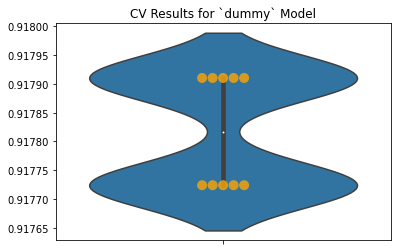

In [30]:
fig,ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)


The model's accuracy on the train set is 0.9178 

The model's recall on the train set is 1.0 

The model's precision on the train set is 0.9178 

The model's f1-score on the train is 0.9571


The model's accuracy on the test set is 0.9175 

The model's recall on the test set is 1.0 

The model's precision on the test set is 0.9175 

The model's f1-score on the test is 0.957



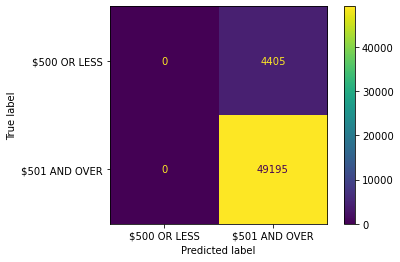

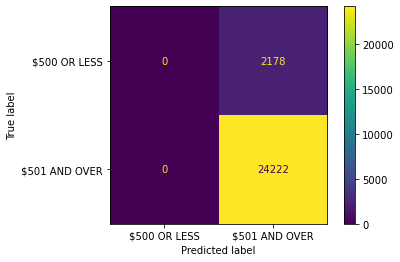

In [141]:
# Fit the model:
dummy_model.fit(X_train, y_train)

# Plot confusion_matrix on training data:
matrix_train_model1 = plot_confusion_matrix(dummy_model, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model1)

# Plot confusion_matrix on testing data:
matrix_test_model1 = plot_confusion_matrix(dummy_model, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model1)

# Print 4 scores on training data:
y_hat_train = dummy_model.predict(X_train)
add_4scores_train('model1')
print_4scores_train('model1')

# Print 4 scores on testing data:
y_hat_test = dummy_model.predict(X_test)
add_4scores_test('model1')
print_4scores_test('model1')

### Model 2: Create FSM (First Simple Model) - Logistic Regression Model

In [33]:
# Reset solver from 'lbfgs' to 'saga', and max_iter = 300

logreg_fsm = Pipeline([
    ('ct',CT),
    ('logreg_fsm',LogisticRegression(random_state=42, solver='saga', max_iter=300))
])

In [34]:
# Use the class with out logreg pipe

fsm_model_pipe =  ModelWithCV(logreg_fsm, model_name='fsm',X=X_train, y=y_train)

# Getting ConvergenceWarning. Go back to logreg_fsm above to reset the parameters.

C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages

In [35]:
# Score on training data:

logreg_score_train = fsm_model_pipe.print_cv_summary()
logreg_score_train

0.9178171641791044

In [36]:
# Validate with testing data:

logreg_score_test = fsm_model_pipe.print_cv_test_summary()
logreg_score_test

0.9175000000000001

<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

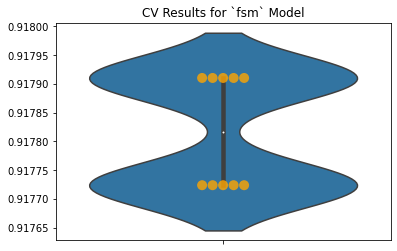

In [37]:
fig,ax = plt.subplots()
fsm_model_pipe.plot_cv(ax=ax)

C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



The model's accuracy on the train set is 0.9178 

The model's recall on the train set is 1.0 

The model's precision on the train set is 0.9178 

The model's f1-score on the train is 0.9571


The model's accuracy on the test set is 0.9175 

The model's recall on the test set is 1.0 

The model's precision on the test set is 0.9175 

The model's f1-score on the test is 0.957



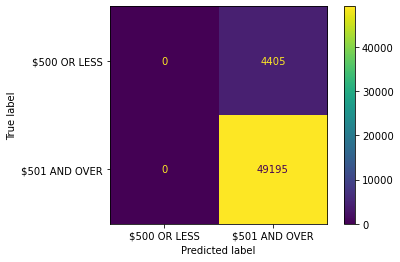

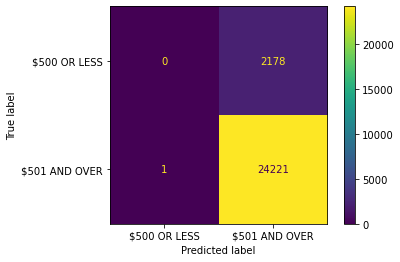

In [38]:
# Fit the model:
logreg_fsm.fit(X_train, y_train)

# Plot confusion_matrix on training data:
matrix_train_model2 = plot_confusion_matrix(logreg_fsm, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model2)

# Plot confusion_matrix on testing data:
matrix_test_model2 = plot_confusion_matrix(logreg_fsm, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model2)

# Print 4 scores on training data:
y_hat_train = logreg_fsm.predict(X_train)
add_4scores_train('model2')
print_4scores_train('model2')

# Print 4 scores on testing data:
y_hat_test = logreg_fsm.predict(X_test)
add_4scores_test('model2')
print_4scores_test('model2')

### Trying Other Models at the End of the Pipeline
### Model 3: Random Forest

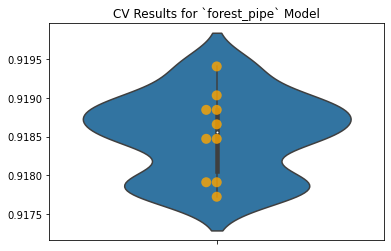

In [39]:
# rfc!
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

In [40]:
# Score on training data:

rfc_score_train = forest_pipe.print_cv_summary()
rfc_score_train

0.918526119402985

In [41]:
# Validate with testing data:

rfc_score_test = forest_pipe.print_cv_test_summary()
rfc_score_test

0.9175378787878788


The model's accuracy on the train set is 0.9998 

The model's recall on the train set is 1.0 

The model's precision on the train set is 0.9998 

The model's f1-score on the train is 0.9999


The model's accuracy on the test set is 0.9185 

The model's recall on the test set is 0.9986 

The model's precision on the test set is 0.9195 

The model's f1-score on the test is 0.9574



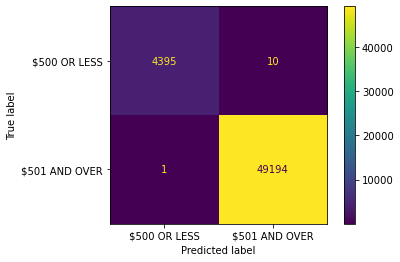

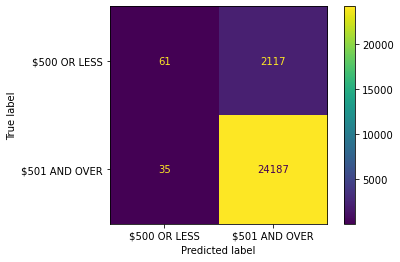

In [43]:
# # Fit the model:
rfc_model_pipe.fit(X_train, y_train)

# Plot confusion_matrix on training data:
matrix_train_model3 = plot_confusion_matrix(rfc_model_pipe, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model3)

# Plot confusion_matrix on testing data:
matrix_test_model3 = plot_confusion_matrix(rfc_model_pipe, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model3)


# Print 4 scores on training data:
y_hat_train = rfc_model_pipe.predict(X_train)
add_4scores_train('model3')
print_4scores_train('model3')

# Print 4 scores on testing data:
y_hat_test = rfc_model_pipe.predict(X_test)
add_4scores_test('model3')
print_4scores_test('model3')


### Model 4: Gradient Booster

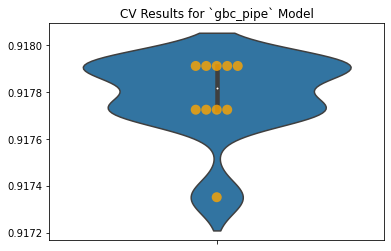

In [44]:
# gbc!
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_pipe = ModelWithCV(model=gbc_model_pipe,
                          model_name='gbc_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax=ax);

In [45]:
# Score on training data:

gbc_score_train = gbc_pipe.print_cv_summary()
gbc_score_train

0.9177798507462687

In [46]:
# Validate with testing data:

gbc_score_test = gbc_pipe.print_cv_test_summary()
gbc_score_test

0.9173484848484849


The model's accuracy on the train set is 0.918 

The model's recall on the train set is 1.0 

The model's precision on the train set is 0.918 

The model's f1-score on the train is 0.9573


The model's accuracy on the test set is 0.9175 

The model's recall on the test set is 1.0 

The model's precision on the test set is 0.9175 

The model's f1-score on the test is 0.957



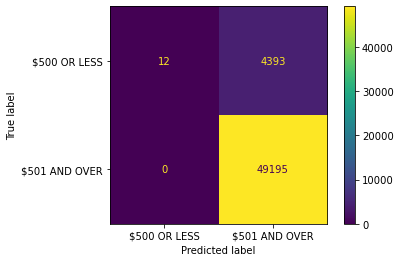

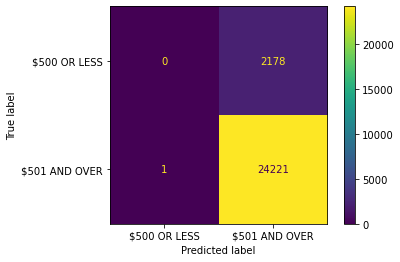

In [47]:
# Fit the model:
gbc_model_pipe.fit(X_train, y_train)

# Plot confusion_matrix on training data:
matrix_train_model4 = plot_confusion_matrix(gbc_model_pipe, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model4)

# Plot confusion_matrix on testing data:
matrix_test_model4 = plot_confusion_matrix(gbc_model_pipe, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model4)

# Print 4 scores on training data:
y_hat_train = gbc_model_pipe.predict(X_train)
add_4scores_train('model4')
print_4scores_train('model4')

# Print 4 scores on testing data:
y_hat_test = gbc_model_pipe.predict(X_test)
add_4scores_test('model4')
print_4scores_test('model4')

## Take out column 'ZIPCODE' and re-run the models
It took 1h 32mins to excute Gradient Booster model.
Decided to take out Column 'ZIPCODE' since this dataset is collected in Chicago. Different 'ZIPCODE' might not impact the target much.

Before taking out ‘ZIPCODE’:
- CV Results for `dummy` model:  0.63879 ± 0.00009 accuracy
- CV Results for `forest_pipe` model:  0.62870 ± 0.00595 accuracy
- CV Results for `gbc_pipe` model:  0.63943 ± 0.00072 accuracy


### Model 5: Decision Tree

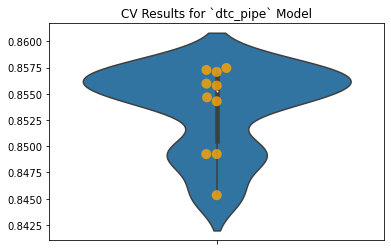

In [48]:
dtc_model_pipe = Pipeline([('ct', CT), ('dtc', DecisionTreeClassifier(random_state=42))])

dtc_pipe = ModelWithCV(model=dtc_model_pipe,
                          model_name='dtc_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

dtc_pipe.plot_cv(ax=ax);

In [49]:
# Score on training data:

dtc_score_train = dtc_pipe.print_cv_summary()
dtc_score_train

0.8536380597014925

In [50]:
# Validate with testing data:

dtc_score_test = dtc_pipe.print_cv_test_summary()
dtc_score_test

0.8530303030303031


The model's accuracy on the train set is 0.9999 

The model's recall on the train set is 0.9999 

The model's precision on the train set is 1.0 

The model's f1-score on the train is 0.9999


The model's accuracy on the test set is 0.8543 

The model's recall on the test set is 0.9167 

The model's precision on the test set is 0.9239 

The model's f1-score on the test is 0.9203



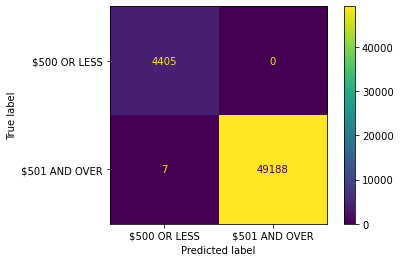

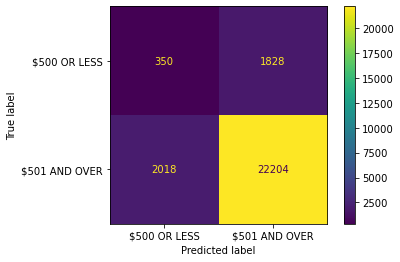

In [51]:
# Fit the model:
dtc_model_pipe.fit(X_train, y_train)

# Plot confusion_matrix on training data:
matrix_train_model5 = plot_confusion_matrix(dtc_model_pipe, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model5)

# Plot confusion_matrix on testing data:
matrix_test_model5 = plot_confusion_matrix(dtc_model_pipe, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model5)

# Print 4 scores on training data:
y_hat_train = dtc_model_pipe.predict(X_train)
add_4scores_train('model5')
print_4scores_train('model5')

# Print 4 scores on testing data:
y_hat_test = dtc_model_pipe.predict(X_test)
add_4scores_test('model5')
print_4scores_test('model5')

### Model 6: Tuning and Cross-Validating - Logistic Regression Model

As a result, Logistic Regression Model has the best accuracy. Tune the Logreg Model and perform GridSearch:

In [75]:
# Checking logreg Pipeline:

logreg_fsm

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AEC0AB6DC0>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [76]:
# Set up parameters:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'logreg_fsm__max_iter':[500, 600],
    'logreg_fsm__class_weight':[None, 'balanced']
}

# Set up GridSearchCV and fit training data:
gs_logreg = GridSearchCV(estimator=logreg_fsm, param_grid=params, cv=10, verbose=2)

gs_logreg.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.0s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.4s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.4s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.3s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  33.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, tot

[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  18.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  18.2s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.4s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logre

[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  20.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  19.7s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  19.4s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  20.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 35.9min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001AEC0AB6DC0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [77]:
gs_logreg.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'logreg_fsm__class_weight': None,
 'logreg_fsm__max_iter': 500}

In [78]:
tunedLogreg_score_train = gs_logreg.best_score_
tunedLogreg_score_train

0.9178171641791044

In [79]:
# Validate with testing data:
tunedLogreg_score_test = gs_logreg.best_estimator_.score(X_test, y_test)
tunedLogreg_score_test

0.9174621212121212


The model's accuracy on the train set is 0.9178 

The model's recall on the train set is 1.0 

The model's precision on the train set is 0.9178 

The model's f1-score on the train is 0.9571


The model's accuracy on the test set is 0.9175 

The model's recall on the test set is 1.0 

The model's precision on the test set is 0.9175 

The model's f1-score on the test is 0.957



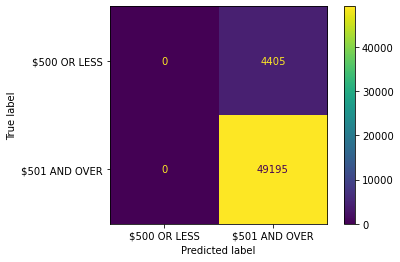

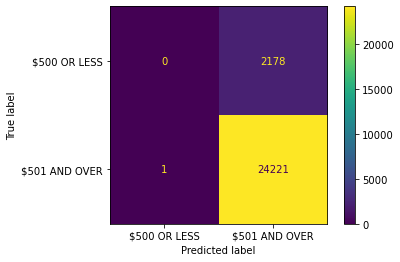

In [80]:
# Plot confusion_matrix on training data:
matrix_train_model6 = plot_confusion_matrix(gs_logreg, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model6)

# Plot confusion_matrix on testing data:
matrix_test_model6 = plot_confusion_matrix(gs_logreg, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model6)

# Print 4 scores on training data:
y_hat_train = gs_logreg.predict(X_train)
add_4scores_train('model6')
print_4scores_train('model6')

# Print 4 scores on testing data:
y_hat_test = gs_logreg.predict(X_test)
add_4scores_test('model6')
print_4scores_test('model6')

### Model 7: Tuning and Cross-Validating - Random Forest Model

In [52]:
# Set up parameters:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'rfc__criterion':['gini','entropy'],
    'rfc__max_depth':[1,3,5]
}

# Set up GridSearchCV and fit training data:
gs_rfc = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=10, verbose=2)

gs_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   2.6s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   2.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   2.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   2.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   2.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   2.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gi

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   3.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   3.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   3.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   3.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   3.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=5 
[CV]  ct__num_trans__num_impute__st

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5, total=   6.6s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5, total=   6.6s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   3.5s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   3.3s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   3.6s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  8.5min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001AEC0AB6DC0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [53]:
gs_rfc.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'rfc__criterion': 'gini',
 'rfc__max_depth': 1}

In [54]:
tunedRfc_score_train = gs_rfc.best_score_
tunedRfc_score_train

0.9178171641791044

In [55]:
# Validate with testing data:
tunedRfc_score_test = gs_rfc.best_estimator_.score(X_test, y_test)
tunedRfc_score_test

0.9175


The model's accuracy on the train set is 0.9178 

The model's recall on the train set is 1.0 

The model's precision on the train set is 0.9178 

The model's f1-score on the train is 0.9571


The model's accuracy on the test set is 0.9175 

The model's recall on the test set is 1.0 

The model's precision on the test set is 0.9175 

The model's f1-score on the test is 0.957



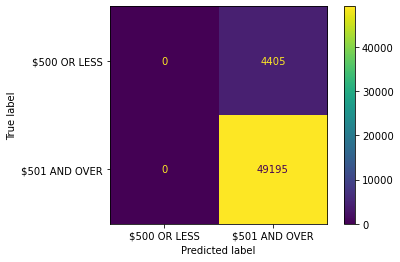

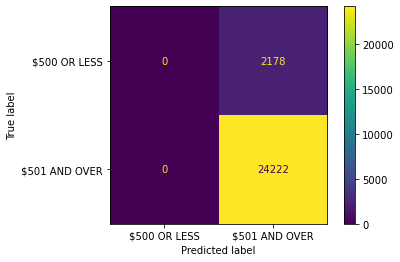

In [56]:
# Plot confusion_matrix on training data:
matrix_train_model7 = plot_confusion_matrix(gs_rfc, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model7)

# Plot confusion_matrix on testing data:
matrix_test_model7 = plot_confusion_matrix(gs_rfc, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model7)

# Print 4 scores on training data:
y_hat_train = gs_rfc.predict(X_train)
add_4scores_train('model7')
print_4scores_train('model7')

# Print 4 scores on testing data:
y_hat_test = gs_rfc.predict(X_test)
add_4scores_test('model7')
print_4scores_test('model7')

## Imblearn Pipelines
Dealing with the Target Imbalance, let's use SMOTE.

In [57]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [58]:
# To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

X_train_clean = X_train.select_dtypes('int64').dropna()
y_train_clean = y_train[X_train_clean.index]

In [59]:
y_train_clean

4285     $501 AND OVER
1010     $501 AND OVER
22088    $501 AND OVER
46536     $500 OR LESS
69791    $501 AND OVER
             ...      
6265     $501 AND OVER
54890    $501 AND OVER
76820     $500 OR LESS
860      $501 AND OVER
15789    $501 AND OVER
Name: DAMAGE, Length: 53600, dtype: object

In [60]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

$501 AND OVER    49195
$500 OR LESS     49195
Name: DAMAGE, dtype: int64

### Model 8-1: ImPipleline with SMOTE (sampling_strategy='auto') and Random Forest Model

In [61]:
# imbpipe!

imb_pipe= ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42)),
    ('rfc',RandomForestClassifier(random_state=42)),
])

imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AEC0AB6DC0>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [62]:
imbRfc_score_train = imb_pipe.score(X_train, y_train)
imbRfc_score_train

0.9998694029850747

In [63]:
# Validate with testing data:
imbRfc_score_test = imb_pipe.score(X_test, y_test)
imbRfc_score_test

0.9065909090909091


The model's accuracy on the train set is 0.9999 

The model's recall on the train set is 0.9999 

The model's precision on the train set is 0.9999 

The model's f1-score on the train is 0.9999


The model's accuracy on the test set is 0.9066 

The model's recall on the test set is 0.9798 

The model's precision on the test set is 0.9231 

The model's f1-score on the test is 0.9506



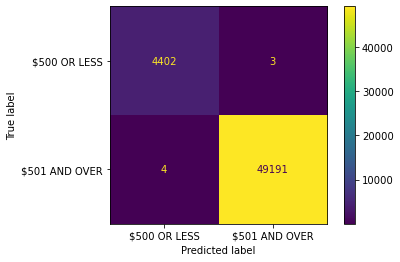

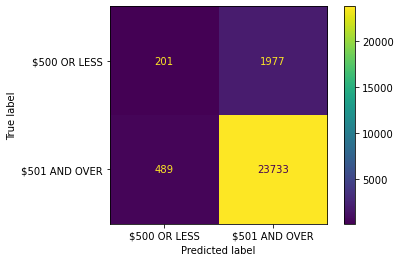

In [64]:
# Plot confusion_matrix on training data:
matrix_train_model81 = plot_confusion_matrix(imb_pipe, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model81)

# Plot confusion_matrix on testing data:
matrix_test_model81 = plot_confusion_matrix(imb_pipe, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model81)

# Print 4 scores on training data:
y_hat_train = imb_pipe.predict(X_train)
add_4scores_train('model81')
print_4scores_train('model81')

# Print 4 scores on testing data:
y_hat_test = imb_pipe.predict(X_test)
add_4scores_test('model81')
print_4scores_test('model81')

### Model 8-2: ImPipleline with SMOTE (sampling_strategy=0.8) and Random Forest Model

In [65]:
imb_pipe80= ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(sampling_strategy=0.8, random_state=42)),
    ('rfc',RandomForestClassifier(random_state=42)),
])

imb_pipe80.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001AEC0AB6DC0>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [66]:
imbRfc80_score_train = imb_pipe.score(X_train, y_train)
imbRfc80_score_train

0.9998694029850747

In [67]:
# Validate with testing data:
imbRfc80_score_test = imb_pipe.score(X_test, y_test)
imbRfc80_score_test

0.9065909090909091


The model's accuracy on the train set is 0.9999 

The model's recall on the train set is 1.0 

The model's precision on the train set is 0.9999 

The model's f1-score on the train is 0.9999


The model's accuracy on the test set is 0.9081 

The model's recall on the test set is 0.982 

The model's precision on the test set is 0.9229 

The model's f1-score on the test is 0.9515



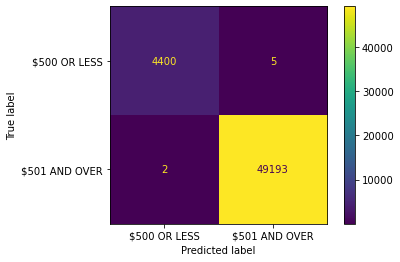

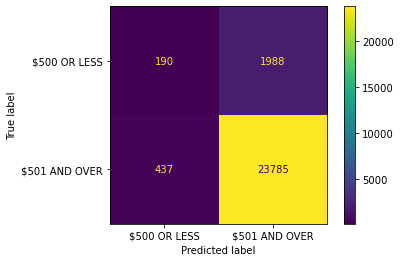

In [68]:
# Plot confusion_matrix on training data:
matrix_train_model82 = plot_confusion_matrix(imb_pipe80, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model82)

# Plot confusion_matrix on testing data:
matrix_test_model82 = plot_confusion_matrix(imb_pipe80, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model82)

# Print 4 scores on training data:
y_hat_train = imb_pipe80.predict(X_train)
add_4scores_train('model82')
print_4scores_train('model82')

# Print 4 scores on testing data:
y_hat_test = imb_pipe80.predict(X_test)
add_4scores_test('model82')
print_4scores_test('model82')

### Model 9: Gridsearching with SMOTE and Random Forest Model

In [69]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 3],
          'sm__k_neighbors': [3, 5]}

gs_smote_rfc = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10, verbose=2)

gs_smote_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  34.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.0s remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  37.9s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  33.3s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  36.6s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  37.2s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  33.3s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  33.4s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighb

[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  40.0s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  39.7s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  38.8s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  39.0s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  38.3s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  38.7s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=3, sm__k_neighbors=3 
[CV]  rfc__criterion=entropy, rfc_

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 50.6min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001AEC0AB6DC0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [70]:
gs_smote_rfc.best_params_

{'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 1, 'sm__k_neighbors': 5}

In [71]:
gsRfc_score_train = gs_smote_rfc.score(X_train, y_train)
gsRfc_score_train

0.9998694029850747

In [72]:
# Validate with testing data:
gsRfc_score_test = gs_smote_rfc.score(X_test, y_test)
gsRfc_score_test

0.9070075757575757


The model's accuracy on the train set is 0.9999 

The model's recall on the train set is 1.0 

The model's precision on the train set is 0.9999 

The model's f1-score on the train is 0.9999


The model's accuracy on the test set is 0.907 

The model's recall on the test set is 0.9802 

The model's precision on the test set is 0.9232 

The model's f1-score on the test is 0.9508



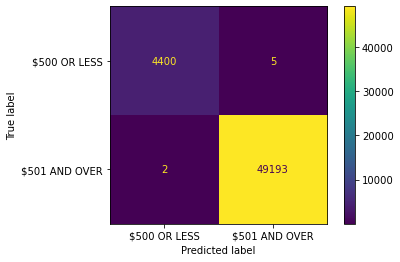

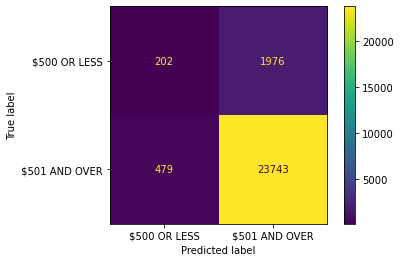

In [73]:
# Plot confusion_matrix on training data:
matrix_train_model9 = plot_confusion_matrix(gs_smote_rfc, X_train, y_train);
cf_matrix_train_list.append(matrix_train_model9)

# Plot confusion_matrix on testing data:
matrix_test_model9 = plot_confusion_matrix(gs_smote_rfc, X_test, y_test);
cf_matrix_test_list.append(matrix_test_model9)

# Print 4 scores on training data:
y_hat_train = gs_smote_rfc.predict(X_train)
add_4scores_train('model9')
print_4scores_train('model9')

# Print 4 scores on testing data:
y_hat_test = gs_smote_rfc.predict(X_test)
add_4scores_test('model9')
print_4scores_test('model9')

## Evaluation and Final Model

### Bring the scores together from all models:

In [81]:
model_list = ['dummy', 'logreg', 'rfc', 'gbc', 'dtc', 'tunedLogreg', 'tunedRfc', 'imbRfc', 'imbRfc80', 'gsRfc']

score_train_list = [] 
score_test_list = []

for i in model_list:
    score_train_list.append(eval(i+'_score_train'))
    score_test_list.append(eval(i+'_score_test'))


In [82]:
df_score_train = pd.DataFrame (score_train_list, columns = ['score_train'], index=model_list)
df_score_test = pd.DataFrame (score_test_list, columns = ['score_test'], index=model_list)
df_score = pd.concat([df_score_train, df_score_test], axis=1)


df_score

,score_train,score_test
dummy,0.917817,0.917500
logreg,0.917817,0.917500
rfc,0.918526,0.917538
gbc,0.917780,0.917348
dtc,0.853638,0.853030
tunedLogreg,0.917817,0.917462
tunedRfc,0.917817,0.917500
imbRfc,0.999869,0.906591
imbRfc80,0.999869,0.906591
gsRfc,0.999869,0.907008


In [83]:
# Score DataFrame:

df_score['difference'] = abs(df_score['score_test']-df_score['score_train'])
df_score

,score_train,score_test,difference
dummy,0.917817,0.917500,0.000317
logreg,0.917817,0.917500,0.000317
rfc,0.918526,0.917538,0.000988
gbc,0.917780,0.917348,0.000431
dtc,0.853638,0.853030,0.000608
tunedLogreg,0.917817,0.917462,0.000355
tunedRfc,0.917817,0.917500,0.000317
imbRfc,0.999869,0.906591,0.093278
imbRfc80,0.999869,0.906591,0.093278
gsRfc,0.999869,0.907008,0.092862


### By looking at the accuracy score tables, the best performing models are:
- dummy (0)
- logreg (1)
- gbc (3)
- runedLogreg (5)
- tunedRfc (6)

best_model_list = [0, 1, 3, 5, 6]

#### Now need to look into their Confusion Matrix and other score

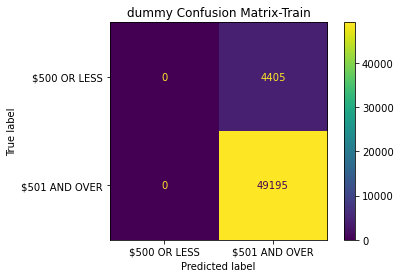

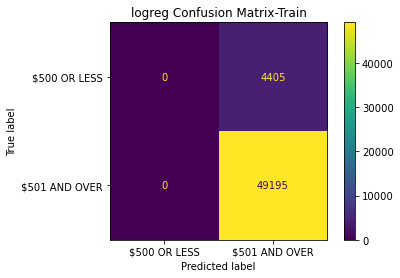

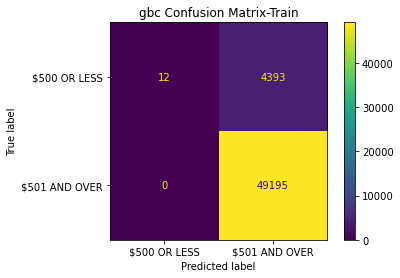

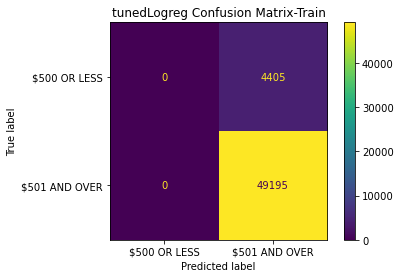

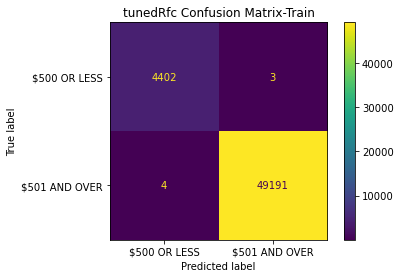

In [100]:
best_model_list = [0, 1, 3, 5, 6]

# Print out the confusion matrix on train data set for the best models:

for i in best_model_list:
    fig = cf_matrix_train_list[i].plot()
    title = model_list[i]+' Confusion Matrix-Train'
    plt.title(title)
    plt.show();

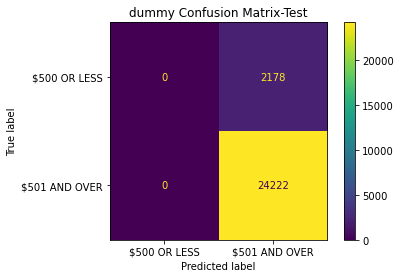

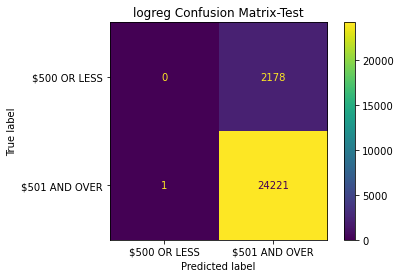

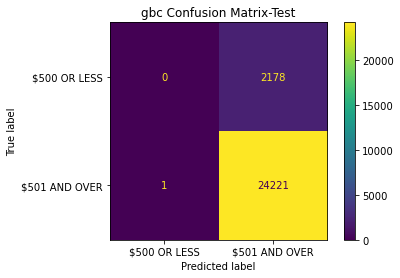

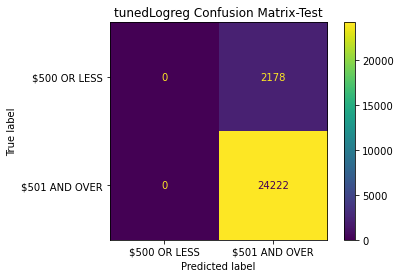

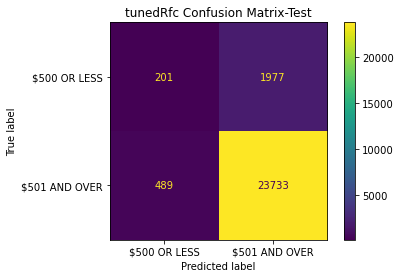

In [101]:
# Print out the confusion matrix on test data set for the best models:

for i in best_model_list:
    fig = cf_matrix_test_list[i].plot()
    title = model_list[i]+' Confusion Matrix-Test'
    plt.title(title)
    plt.show();

### The best model is tunedRfc!
This model can predict both of the positive target (501 AND MORE) and negative target ($500 OR LESS).  Others can't predict negative target well.  However the sacrifice is higher False Positive (1977) and False Negative (489). 

## Final Model = tunedRfc!

### Review all models' scores and final model's score visualization. 

In [ ]:
accuracy_train_dict = {}
recall_train_dict = {}
precision_train_dict = {}
f1_train_dict = {}

accuracy_test_dict = {}
recall_test_dict = {}
precision_test_dict = {}
f1_test_dict = {}

In [126]:
All4scores_train_list = [accuracy_train_dict, recall_train_dict, precision_train_dict, f1_train_dict]
df_4scores_train = pd.DataFrame(All4scores_train_list).T
df_4scores_train.columns = ['accuracy_train', 'recall_train', 'precision_train', 'f1_train']
df_4scores_train

,accuracy_train,recall_train,precision_train,f1_train
model1,0.917817,1.000000,0.917817,0.957148
model2,0.917817,1.000000,0.917817,0.957148
model3,0.999795,0.999980,0.999797,0.999888
model4,0.918041,1.000000,0.918023,0.957259
model5,0.999869,0.999858,1.000000,0.999929
model7,0.917817,1.000000,0.917817,0.957148
model81,0.999869,0.999919,0.999939,0.999929
model82,0.999869,0.999959,0.999898,0.999929
model9,0.999869,0.999959,0.999898,0.999929
model6,0.917817,1.000000,0.917817,0.957148


In [127]:
All4scores_test_list = [accuracy_test_dict, recall_test_dict, precision_test_dict, f1_test_dict]
df_4scores_test = pd.DataFrame(All4scores_test_list).T
df_4scores_test.columns = ['accuracy_test', 'recall_test', 'precision_test', 'f1_test']
df_4scores_test

,accuracy_test,recall_test,precision_test,f1_test
model1,0.917500,1.000000,0.917500,0.956975
model2,0.917462,0.999959,0.917497,0.956955
model3,0.918485,0.998555,0.919518,0.957408
model4,0.917462,0.999959,0.917497,0.956955
model5,0.854318,0.916687,0.923935,0.920297
model7,0.917500,1.000000,0.917500,0.956975
model81,0.906591,0.979812,0.923104,0.950613
model82,0.908144,0.981959,0.922865,0.951495
model9,0.907008,0.980225,0.923170,0.950842
model6,0.917462,0.999959,0.917497,0.956955


In [134]:
df_4scores = df_4scores_train.merge(df_4scores_test, left_index=True, right_index=True)
df_4scores.columns

Index(['accuracy_train', 'recall_train', 'precision_train', 'f1_train',
       'accuracy_test', 'recall_test', 'precision_test', 'f1_test'],
      dtype='object')

In [135]:
df_4scores.columns = ['accuracy_train', 'accuracy_test',
                      'recall_train', 'recall_test',
                      'precision_train', 'precision_test',
                      'f1_train', 'f1_test']

In [136]:
df_4scores

,accuracy_train,accuracy_test,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test
model1,0.917817,1.000000,0.917817,0.957148,0.917500,1.000000,0.917500,0.956975
model2,0.917817,1.000000,0.917817,0.957148,0.917462,0.999959,0.917497,0.956955
model3,0.999795,0.999980,0.999797,0.999888,0.918485,0.998555,0.919518,0.957408
model4,0.918041,1.000000,0.918023,0.957259,0.917462,0.999959,0.917497,0.956955
model5,0.999869,0.999858,1.000000,0.999929,0.854318,0.916687,0.923935,0.920297
model7,0.917817,1.000000,0.917817,0.957148,0.917500,1.000000,0.917500,0.956975
model81,0.999869,0.999919,0.999939,0.999929,0.906591,0.979812,0.923104,0.950613
model82,0.999869,0.999959,0.999898,0.999929,0.908144,0.981959,0.922865,0.951495
model9,0.999869,0.999959,0.999898,0.999929,0.907008,0.980225,0.923170,0.950842
model6,0.917817,1.000000,0.917817,0.957148,0.917462,0.999959,0.917497,0.956955


### All Models' scroes

In [145]:
df_4scores = df_4scores.sort_index(axis = 0)
df_4scores

,accuracy_train,accuracy_test,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test
model1,0.917817,1.000000,0.917817,0.957148,0.917500,1.000000,0.917500,0.956975
model2,0.917817,1.000000,0.917817,0.957148,0.917462,0.999959,0.917497,0.956955
model3,0.999795,0.999980,0.999797,0.999888,0.918485,0.998555,0.919518,0.957408
model4,0.918041,1.000000,0.918023,0.957259,0.917462,0.999959,0.917497,0.956955
model5,0.999869,0.999858,1.000000,0.999929,0.854318,0.916687,0.923935,0.920297
model6,0.917817,1.000000,0.917817,0.957148,0.917462,0.999959,0.917497,0.956955
model7,0.917817,1.000000,0.917817,0.957148,0.917500,1.000000,0.917500,0.956975
model81,0.999869,0.999919,0.999939,0.999929,0.906591,0.979812,0.923104,0.950613
model82,0.999869,0.999959,0.999898,0.999929,0.908144,0.981959,0.922865,0.951495
model9,0.999869,0.999959,0.999898,0.999929,0.907008,0.980225,0.923170,0.950842


### Final model (tunedRfc) score visualization

In [186]:
plt.style.use('ggplot')

In [158]:
# Model mean accuracy score:

df_final_model_score = df_score.iloc[6, 0:2]
df_final_model_score

pandas.core.series.Series

In [160]:
df_4scores.iloc[6]

accuracy_train     0.917817
accuracy_test      1.000000
recall_train       0.917817
recall_test        0.957148
precision_train    0.917500
precision_test     1.000000
f1_train           0.917500
f1_test            0.956975
Name: model7, dtype: float64

In [174]:
df_FinalModel = pd.DataFrame(df_final_model_score.append(df_4scores.iloc[6])).T
df_FinalModel.index = ['tunedRFC']
df_FinalModel.rename({'score_train': 'model_score_train',
                      'score_test': 'model_score_test'}, axis=1, inplace=True)
df_FinalModel

,model_score_train,model_score_test,accuracy_train,accuracy_test,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test
tunedRFC,0.917817,0.9175,0.917817,1.0,0.917817,0.957148,0.9175,1.0,0.9175,0.956975


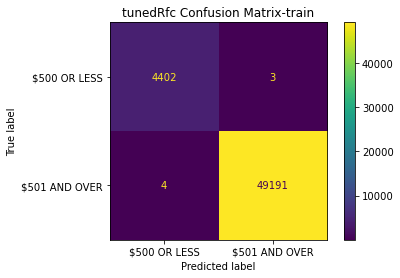

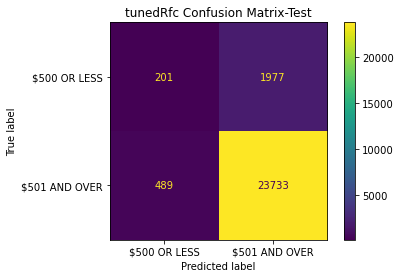

In [172]:
# Confusion matrix for the final model:

fig = cf_matrix_train_list[6].plot()
title = 'tunedRfc Confusion Matrix-train'
plt.title(title)
plt.show();

fig = cf_matrix_test_list[6].plot()
title = 'tunedRfc Confusion Matrix-Test'
plt.title(title)
plt.show();

## Perform prediction on a new observation

Set up the final model using the best parameters results from the best model: tunedRfc

In [255]:
# Fit and transform X_train using ColumnTransformer:
X_train_CT = CT.fit_transform(X_train)

# Final model set up:
final_model = RandomForestClassifier(random_state=42, max_depth=1, criterion='gini')

# fit training data to the model:
final_model.fit(X_train_CT, y_train)

RandomForestClassifier(max_depth=1, random_state=42)

In [270]:
# Randomly pick a row from X_train as new observation:

X_train.iloc[56]

DEVICE_CONDITION        FUNCTIONING PROPERLY
POSTED_SPEED_LIMIT                        35
WEATHER_CONDITION                      CLEAR
LIGHTING_CONDITION                  DAYLIGHT
ROADWAY_SURFACE_COND                     DRY
ROAD_DEFECT                       NO DEFECTS
ZIPCODE                                60612
SEX                                        M
AGE                                       31
MAKE                               CHEVROLET
MODEL                                  TAHOE
VEHICLE_YEAR                            2009
Name: 70306, dtype: object

In [271]:
new_data = pd.DataFrame(X_train.iloc[56]).T
new_data

,DEVICE_CONDITION,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT,ZIPCODE,SEX,AGE,MAKE,MODEL,VEHICLE_YEAR
70306,FUNCTIONING PROPERLY,35,CLEAR,DAYLIGHT,DRY,NO DEFECTS,60612,M,31,CHEVROLET,TAHOE,2009


In [272]:
final_model.predict(CT.transform(new_data))

array(['$501 AND OVER'], dtype=object)

### For this new observation, a 35 ys Male lives in 60612, driving a 2009 Chevrolet Tahoe during daytime while the speed limit is 35 and the  weather and road conditions are prefect, with all traffic device working functionally, we predict the damage to his car is OVER 501 if he has an car accident.

In [308]:
X_train.iloc[999]

DEVICE_CONDITION        NO CONTROLS
POSTED_SPEED_LIMIT               30
WEATHER_CONDITION             CLEAR
LIGHTING_CONDITION         DAYLIGHT
ROADWAY_SURFACE_COND            DRY
ROAD_DEFECT              NO DEFECTS
ZIPCODE                       60636
SEX                               M
AGE                              59
MAKE                          HONDA
MODEL                        ACCORD
VEHICLE_YEAR                   2021
Name: 54137, dtype: object

In [278]:
new_data2 = pd.DataFrame(X_train.iloc[999]).T
new_data2

,DEVICE_CONDITION,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT,ZIPCODE,SEX,AGE,MAKE,MODEL,VEHICLE_YEAR
54137,NO CONTROLS,30,CLEAR,DAYLIGHT,DRY,NO DEFECTS,60636,M,59,HONDA,ACCORD,2021


In [277]:
final_model.predict(CT.transform(new_data2))

array(['$501 AND OVER'], dtype=object)